# Задача

**На основании имеющихся данных о клиентах банка, построить модель, используя датасет для обучения, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.**

**Наименование файлов с данными**

course_project_train.csv - датасет для обучения<br>
course_project_test.csv - тестовый датасет<br>
course_project_answers.csv - датасет с ответами

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5, Precision > 0.5, recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка благонадежности клиента (скоринговый балл, полученный из другого источника)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score as f1
from sklearn.metrics import classification_report, precision_score, recall_score

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# для воспроизводимости результатов
rnd_st = 42

# Обзор данных

### Пути к файлам

In [3]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
ANSWERS_DATASET_PATH = 'course_project_answers.csv'

# output
OUT_PRED_PATH = 'NErmolenko_predictions.csv'

### Чтение файлов

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

train_df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [5]:
test_df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
7,Rent,1215867.0,3 years,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,debt consolidation,Short Term,407726.0,120099.0,7599.0,701.0
8,Rent,NaN,5 years,0.0,8.0,9.1,370524.0,0.0,NaN,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
9,Home Mortgage,2140445.0,10+ years,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,debt consolidation,Short Term,391336.0,294500.0,18372.0,745.0


### Посмотрим размер

In [6]:
print(f"Size of the train df is {train_df.shape}")
print(f"Size of the test df is {test_df.shape}")

Size of the train df is (7500, 17)
Size of the test df is (2500, 16)


### Посмотрим сбалансированность целевых классов в тренировочной выборке

In [7]:
train_df["Credit Default"].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

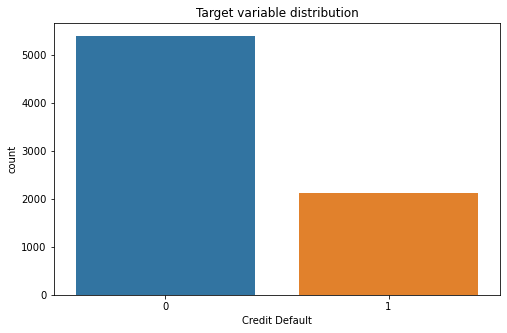

In [8]:
plt.figure(figsize=(8, 5))

sns.countplot(x="Credit Default", data=train_df)

plt.title('Target variable distribution')
plt.show()

Тренеровочную выборку можно считать сбаланстрованной.

### Корреляция с базовыми признаками

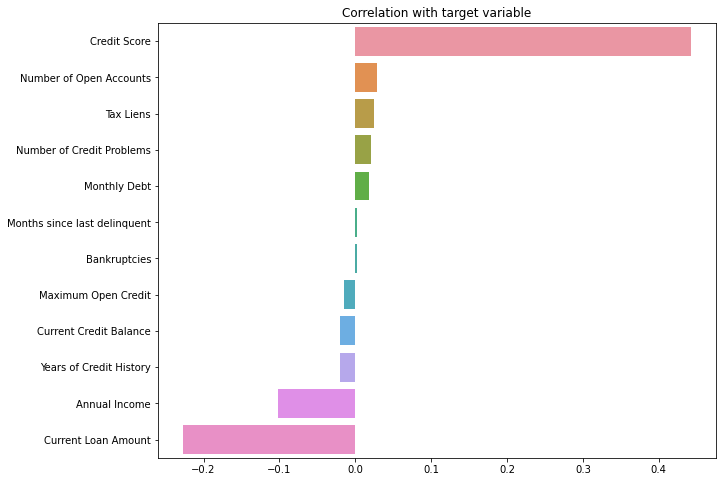

In [9]:
corr_with_target = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ признакового пространства

**Матрица корреляций**

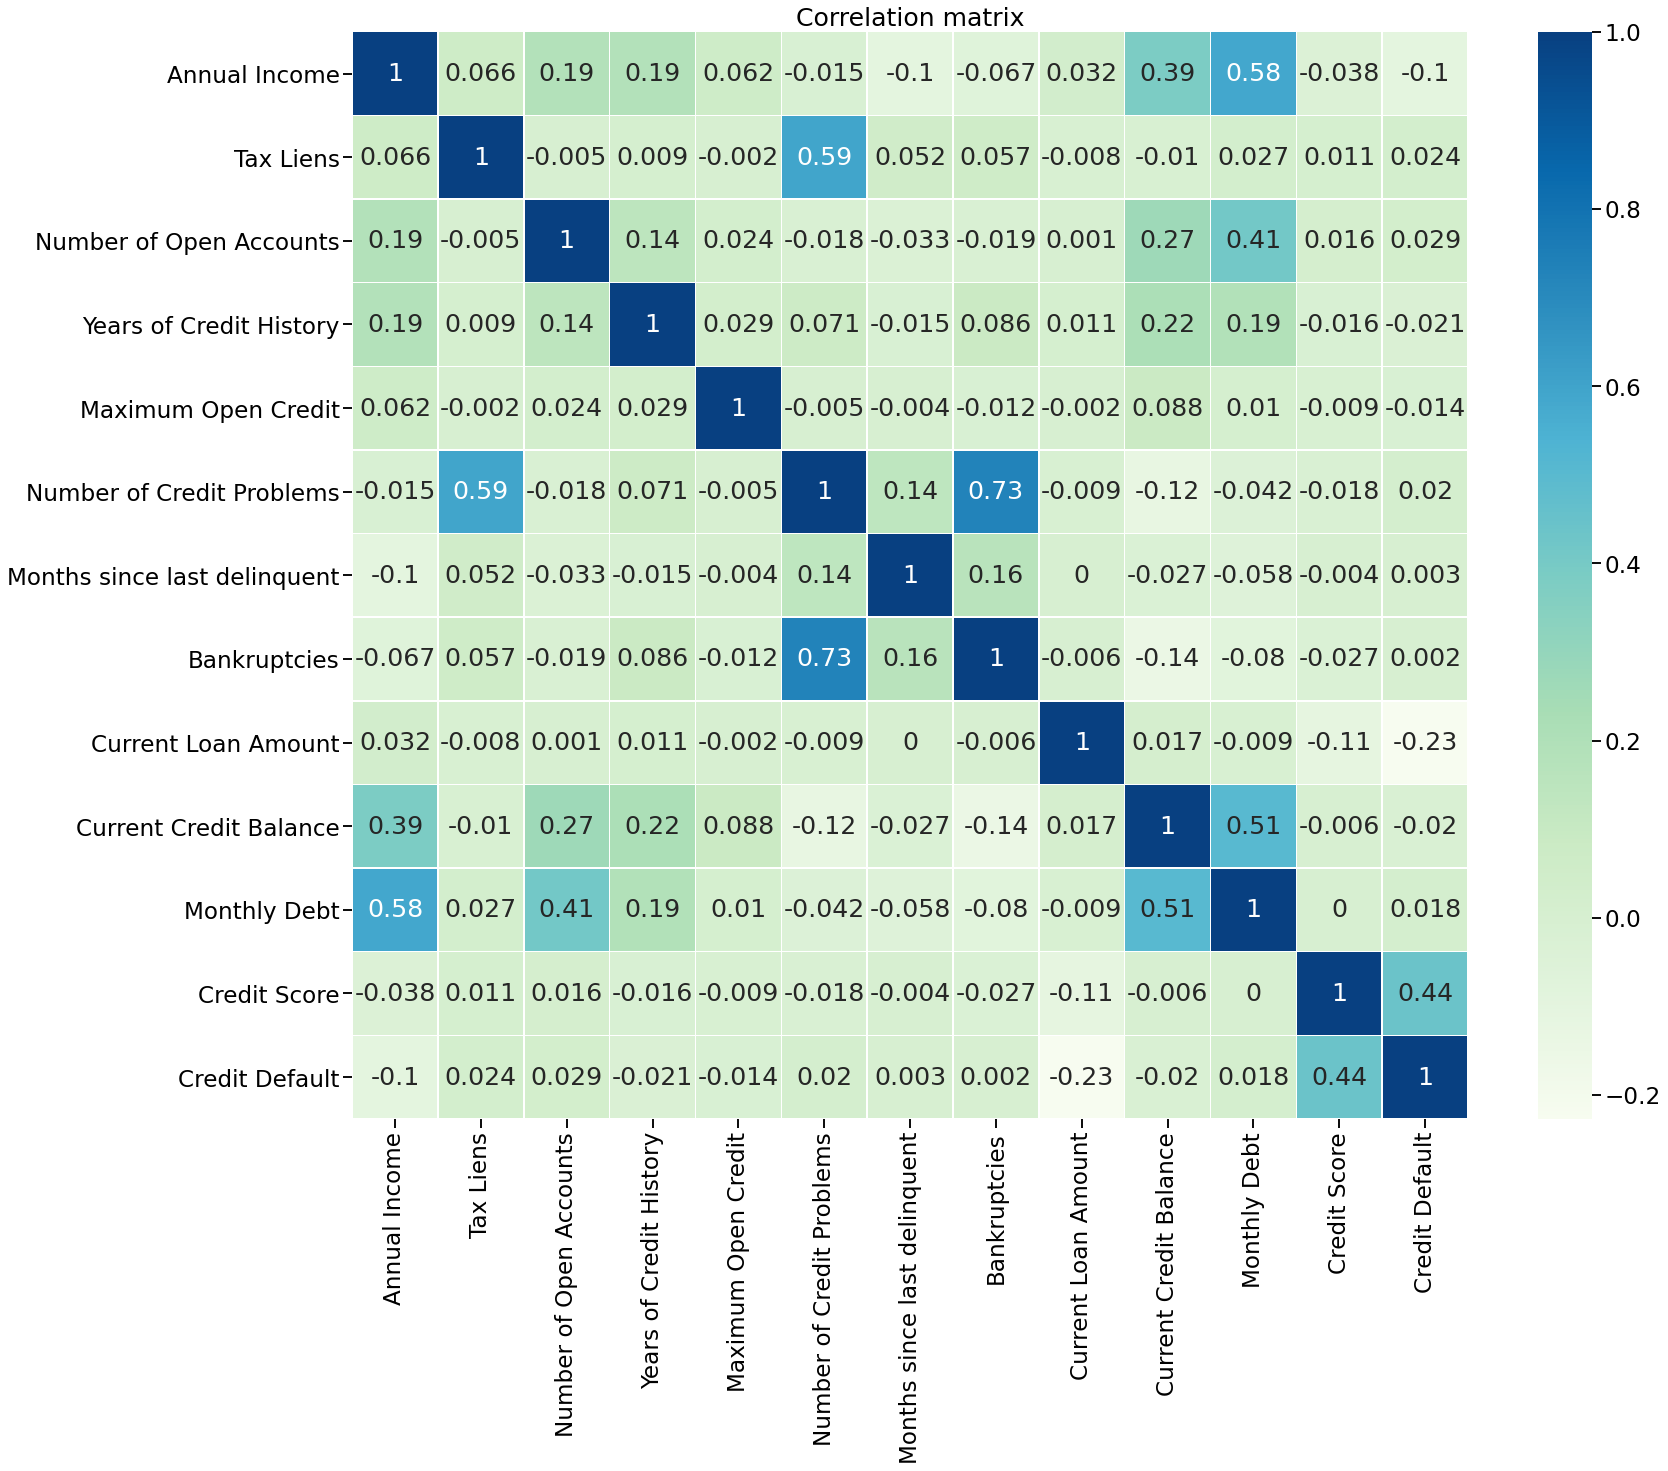

In [10]:
plt.figure(figsize = (25,20))

# sns.set(font_scale=1.4)
sns.set_context("talk", font_scale=1.4)
sns.heatmap(train_df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Посмотрим типы данных признаков

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Посмотрим категориальные признаки

In [12]:
train_df["Home Ownership"].value_counts(normalize=True)

Home Mortgage    0.484933
Rent             0.427200
Own Home         0.086267
Have Mortgage    0.001600
Name: Home Ownership, dtype: float64

Представителей категории "Have Mortgage" слишком мало. Возможно, их лучше объединить с "Home Mortgage".

In [13]:
train_df["Years in current job"].value_counts(normalize=True)

10+ years    0.327115
2 years      0.098892
3 years      0.086969
< 1 year     0.078973
5 years      0.072380
1 year       0.070697
4 years      0.065788
6 years      0.059756
7 years      0.055548
8 years      0.047552
9 years      0.036330
Name: Years in current job, dtype: float64

Представителей 8 и 9 лет слишком мало. Возможно имеет смысл разбить на "укрупнённые" категории.

In [14]:
train_df["Purpose"].value_counts(normalize=True)

debt consolidation      0.792533
other                   0.088667
home improvements       0.054933
business loan           0.017200
buy a car               0.012800
medical bills           0.009467
major purchase          0.005333
take a trip             0.004933
buy house               0.004533
small business          0.003467
wedding                 0.002000
moving                  0.001467
educational expenses    0.001333
vacation                0.001067
renewable energy        0.000267
Name: Purpose, dtype: float64

Все цели, кроме "debt consolidation" и "home improvements", имеет смысл отнести к категории "others". Стоит задуматься о полезности этого признака.

In [15]:
train_df["Term"].value_counts(normalize=True)

Short Term    0.7408
Long Term     0.2592
Name: Term, dtype: float64

### Посмотрим на распределения числовых признаков

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001CFE57C0>,
      dtype=object)

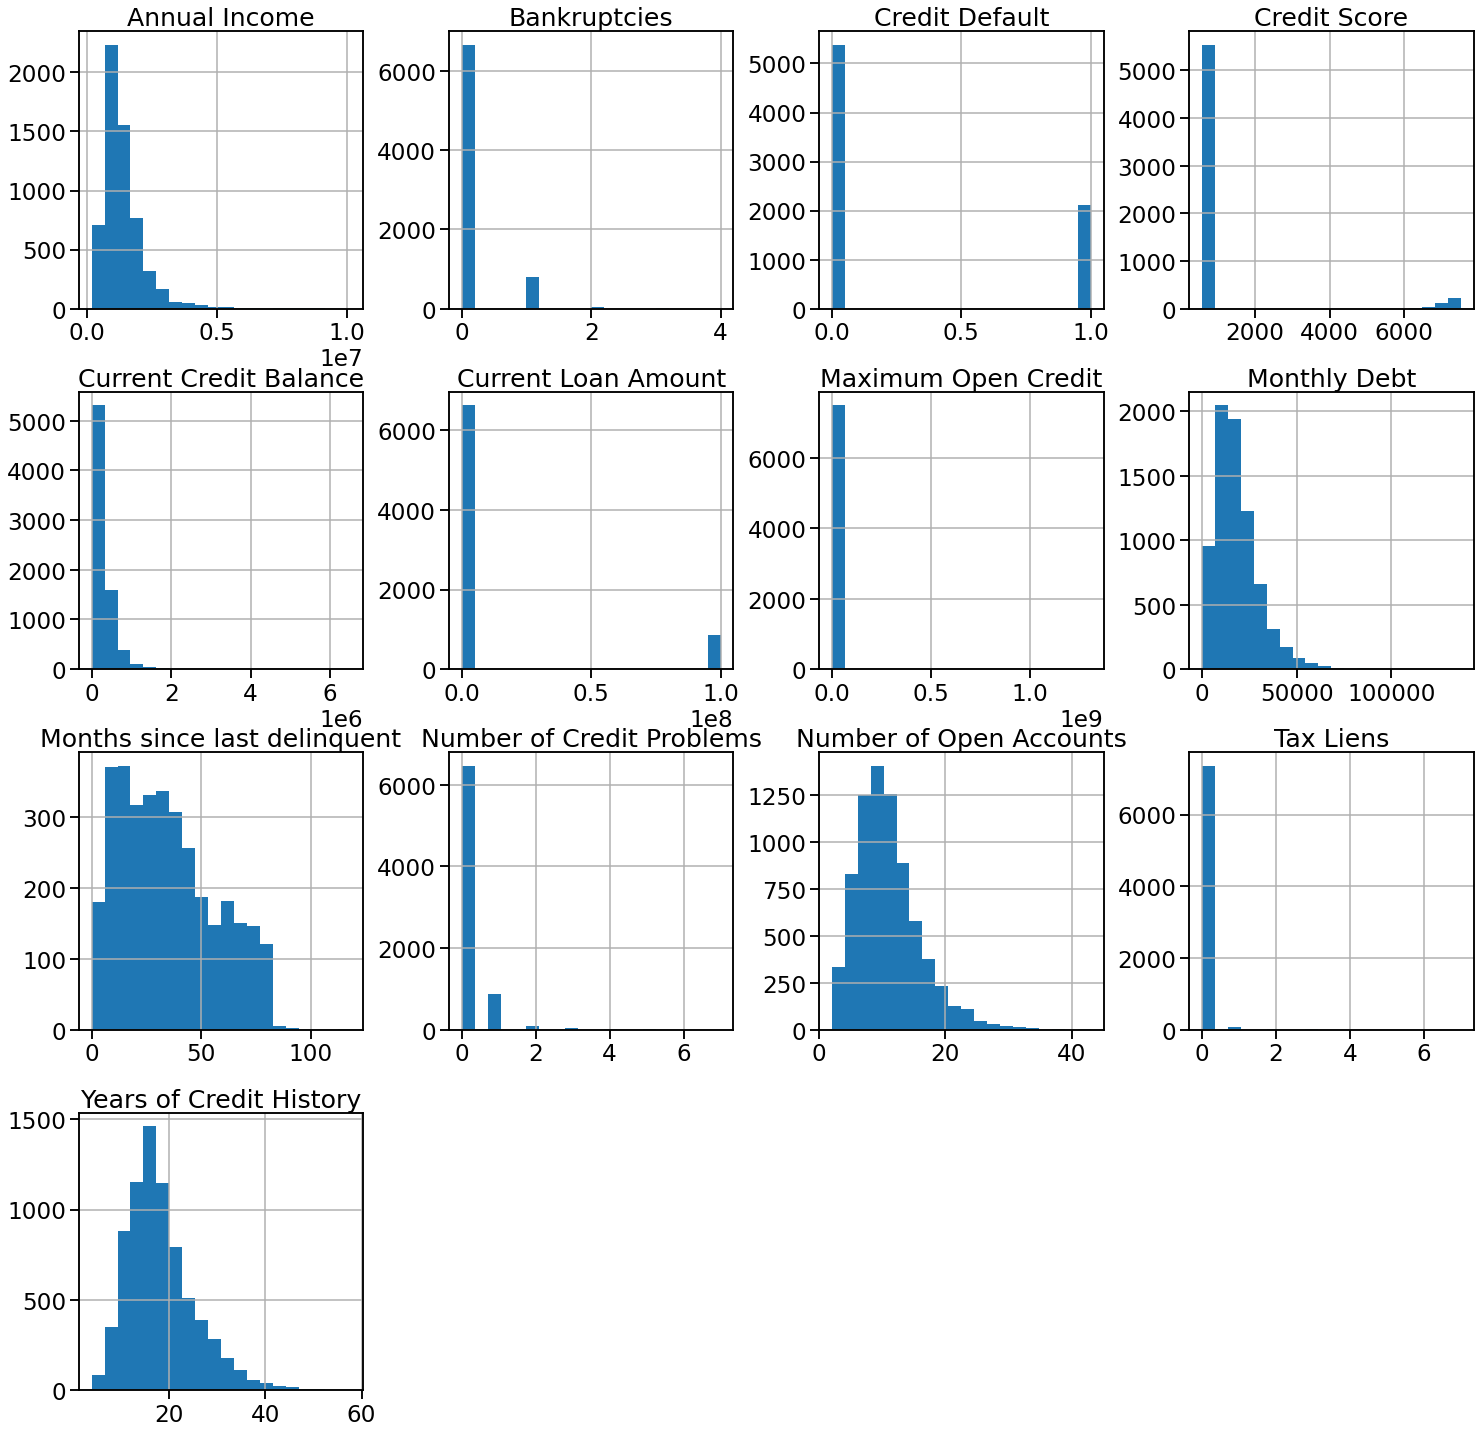

In [16]:
train_hist = train_df.select_dtypes(include=['float64', 'int64'])
train_hist.hist(figsize=(25, 25), bins=20)

In [17]:
train_df["Bankruptcies"].value_counts(normalize=True)

0.0    0.889661
1.0    0.104996
2.0    0.004141
3.0    0.000935
4.0    0.000267
Name: Bankruptcies, dtype: float64

Признак "Bankruptcies" лучше сделать категориальным, и разбить на категории: "Не был банкротом", "Был банкротом единажды", "Был банкротом многократно". Или на "Не был банкротом", "Был банкротом".

In [18]:
train_df["Current Loan Amount"].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

Подозрительное значение 99999999 !

In [19]:
train_df.loc[train_df["Current Loan Amount"] == 99999999]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,Rent,1406836.0,1 year,0.0,12.0,22.6,2383260.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,461054.0,7386.0,747.0,0
7445,Home Mortgage,1564384.0,6 years,0.0,21.0,17.3,1545016.0,0.0,NaN,0.0,other,Long Term,99999999.0,1043442.0,32461.0,728.0,0
7464,Home Mortgage,1159152.0,6 years,0.0,14.0,22.0,389356.0,1.0,77.0,1.0,debt consolidation,Short Term,99999999.0,49438.0,18257.0,737.0,0
7475,Rent,848426.0,10+ years,0.0,8.0,20.1,526306.0,0.0,12.0,0.0,debt consolidation,Short Term,99999999.0,83638.0,16473.0,742.0,0


In [20]:
train_df.loc[train_df["Maximum Open Credit"] > 10000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
354,Home Mortgage,2126537.0,10+ years,0.0,23.0,23.0,1.476048e+07,0.0,NaN,0.0,debt consolidation,Long Term,778624.0,1019806.0,40227.0,697.0,0
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
1476,Own Home,NaN,8 years,0.0,14.0,28.9,1.042866e+07,0.0,NaN,0.0,debt consolidation,Short Term,656766.0,1089802.0,16531.0,NaN,0
1879,Home Mortgage,1433835.0,6 years,0.0,8.0,17.8,1.270144e+07,0.0,35.0,0.0,debt consolidation,Short Term,197384.0,1985462.0,14099.0,749.0,0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0
2468,Home Mortgage,5589420.0,4 years,0.0,11.0,12.3,1.634591e+07,0.0,24.0,0.0,home improvements,Long Term,99999999.0,2315169.0,74991.0,735.0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,99999999.0,1908550.0,5770.0,743.0,0
3170,Home Mortgage,2226230.0,10+ years,0.0,20.0,19.0,1.868381e+07,0.0,NaN,0.0,buy a car,Short Term,111892.0,2355867.0,17123.0,750.0,0


In [21]:
train_df["Number of Credit Problems"].value_counts(normalize=True)

0.0    0.862533
1.0    0.117600
2.0    0.012400
3.0    0.004667
4.0    0.001200
5.0    0.000933
6.0    0.000533
7.0    0.000133
Name: Number of Credit Problems, dtype: float64

Так же, как и с банкротством, имеет смысл разбить на 2 или 3 категории.

In [22]:
train_df["Tax Liens"].value_counts(normalize=True)

0.0    0.982133
1.0    0.011067
2.0    0.004000
3.0    0.001333
4.0    0.000800
5.0    0.000267
6.0    0.000267
7.0    0.000133
Name: Tax Liens, dtype: float64

Возможно, от этого признака лучше отказаться. Слишком мало представителей с льготами.

### Посмотрим основные статистики

In [23]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


### Посмотрим количество пропусков в признаках

In [24]:
train_df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [25]:
test_df.isnull().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

# Предобработка данных

### Перемешаем данные

In [26]:
train_df = train_df.sample(frac=1, random_state=rnd_st).reset_index(drop=True)
train_df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Home Mortgage,2396375.0,6 years,0.0,9.0,10.5,335280.0,1.0,8.0,1.0,debt consolidation,Short Term,621544.0,139859.0,33350.0,7130.0,1
1,Home Mortgage,NaN,5 years,0.0,8.0,14.0,883014.0,0.0,NaN,0.0,debt consolidation,Short Term,157256.0,183027.0,3492.0,NaN,0
2,Home Mortgage,2056351.0,10+ years,0.0,17.0,14.0,1022714.0,0.0,NaN,0.0,debt consolidation,Long Term,601744.0,391286.0,29132.0,718.0,0
3,Home Mortgage,NaN,10+ years,0.0,12.0,16.4,312356.0,0.0,NaN,0.0,debt consolidation,Short Term,215424.0,161329.0,7625.0,NaN,0
4,Rent,817551.0,6 years,0.0,8.0,8.8,279620.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,155990.0,3781.0,740.0,0
5,Rent,NaN,8 years,0.0,16.0,34.0,1083588.0,0.0,25.0,0.0,other,Short Term,112046.0,265772.0,16023.0,NaN,0
6,Home Mortgage,2274300.0,4 years,0.0,10.0,19.4,366410.0,1.0,NaN,1.0,debt consolidation,Short Term,109736.0,224675.0,9779.0,719.0,1
7,Home Mortgage,1292399.0,10+ years,0.0,15.0,16.0,508926.0,0.0,7.0,0.0,home improvements,Long Term,262152.0,185915.0,22186.0,697.0,1
8,Own Home,1155276.0,NaN,0.0,11.0,29.5,858990.0,0.0,34.0,0.0,debt consolidation,Long Term,534512.0,349410.0,15211.0,720.0,0
9,Home Mortgage,2497664.0,8 years,0.0,11.0,28.5,1718046.0,0.0,NaN,0.0,debt consolidation,Long Term,775698.0,1235969.0,51036.0,6810.0,1


### Отделим целевой признак

In [27]:
train_X_df = train_df.copy()
train_Y_sr = train_X_df["Credit Default"]
train_X_df.drop("Credit Default", axis=1, inplace=True)

### Функция предобработки данных

In [28]:
def data_preparing(X_df, medians, modes, means, y=None):
    
    X = X_df.copy()
    
    # пропуски дохода заполним медианным значением
    X.loc[X["Annual Income"].isnull(), "Annual Income"] = 0 #medians["Annual Income"]
    
    # пропуски будем оценивать, как отсутствие работы, пропуски заполним нулями
    X.loc[X["Years in current job"].isnull(), "Years in current job"] = '0'
    
    # Приведём признак с льготами к целочисленному типу, чтобы использовать его, как категориальный
    X["Tax Liens"] = X["Tax Liens"].astype(int)
    
    # пропуск количества месяцев с последней просрочки будем воспринемать, как отсутсвие просрочки (выставим в 60 лет)
    X.loc[X["Months since last delinquent"].isnull(), "Months since last delinquent"] = 720
    
    # Заполним пропуски "Количества банкротств" нулями 
    X.loc[X["Bankruptcies"].isnull(), "Bankruptcies"] = 0
    
    # откажемся от некоторой информации о цели кредита
    X.loc[(X["Purpose"] != "debt consolidation") & (X["Purpose"] != "home improvements") & (X["Purpose"] != "business loan") & (X["Purpose"] != "buy a car"), "Purpose"] = "other"

    # Кредитный рейтинг установим в 0 для тех у кого пропуск
    X.loc[X["Credit Score"].isnull(), "Credit Score"] = 0 
  
    # Внесём категориальные интовые признаки в список категориальных
    cat_features_names = ["Tax Liens"]
    
    return X, cat_features_names

In [29]:
train_medians = train_X_df.median()
train_mods = train_X_df.mode()
train_means = train_X_df.mean()

X_train, CAT_FEATURE_NAMES = data_preparing(train_X_df, train_medians, train_mods, train_means)
CAT_FEATURE_NAMES.extend(X_train.select_dtypes(include=['object']).columns.tolist())
X_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Home Mortgage,2396375.0,6 years,0,9.0,10.5,335280.0,1.0,8.0,1.0,debt consolidation,Short Term,621544.0,139859.0,33350.0,7130.0
1,Home Mortgage,0.0,5 years,0,8.0,14.0,883014.0,0.0,720.0,0.0,debt consolidation,Short Term,157256.0,183027.0,3492.0,0.0
2,Home Mortgage,2056351.0,10+ years,0,17.0,14.0,1022714.0,0.0,720.0,0.0,debt consolidation,Long Term,601744.0,391286.0,29132.0,718.0
3,Home Mortgage,0.0,10+ years,0,12.0,16.4,312356.0,0.0,720.0,0.0,debt consolidation,Short Term,215424.0,161329.0,7625.0,0.0
4,Rent,817551.0,6 years,0,8.0,8.8,279620.0,0.0,720.0,0.0,debt consolidation,Short Term,99999999.0,155990.0,3781.0,740.0
5,Rent,0.0,8 years,0,16.0,34.0,1083588.0,0.0,25.0,0.0,other,Short Term,112046.0,265772.0,16023.0,0.0
6,Home Mortgage,2274300.0,4 years,0,10.0,19.4,366410.0,1.0,720.0,1.0,debt consolidation,Short Term,109736.0,224675.0,9779.0,719.0
7,Home Mortgage,1292399.0,10+ years,0,15.0,16.0,508926.0,0.0,7.0,0.0,home improvements,Long Term,262152.0,185915.0,22186.0,697.0
8,Own Home,1155276.0,0,0,11.0,29.5,858990.0,0.0,34.0,0.0,debt consolidation,Long Term,534512.0,349410.0,15211.0,720.0
9,Home Mortgage,2497664.0,8 years,0,11.0,28.5,1718046.0,0.0,720.0,0.0,debt consolidation,Long Term,775698.0,1235969.0,51036.0,6810.0


# Обучение модели

### Функция кросс-валидации

In [30]:
def cross_validation(X, y, model):
    #     import ipdb; ipdb.set_trace() # debugging starts here
    test_len = int(X.shape[0] * 0.2)

    f1_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    pr_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    rec_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    cm = [0, 0, 0, 0, 0]

    for i in range(5):

        start = i * test_len

        X_test = X.loc[start: (start + test_len - 1), :]
        y_test = y.loc[start: (start + test_len - 1)]

        X_Train_1 = X.loc[:(start - 1), :]
        X_Train_2 = X.loc[(start + test_len):, :]
        X_Train = pd.concat([X_Train_1, X_Train_2], axis=0)
        y_Train_1 = y.loc[:(start - 1)]
        y_Train_2 = y.loc[(start + test_len):]
        y_Train = pd.concat([y_Train_1, y_Train_2], axis=0)

        model.fit(X_Train, y_Train)

        y_pred = model.predict(X_test)

        f1_arr[i] = f1(y_test, y_pred)
        pr_arr[i] = precision_score(y_test, y_pred)
        rec_arr[i] = recall_score(y_test, y_pred)
        cm[i] = confusion_matrix(y_test, y_pred)
        
        print(classification_report(y_test, y_pred))

    return f1_arr, pr_arr, rec_arr, cm

### Задаём модель

In [31]:
CAT_FEATURE_NAMES

['Tax Liens', 'Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [32]:
# лучшая модель полученная подбором
clf = CatBoostClassifier(auto_class_weights="Balanced", silent=True, eval_metric='F1', depth=4, cat_features=CAT_FEATURE_NAMES , random_state=rnd_st)

### Кросс-валидация

In [33]:
f1_sc, pr_sc, rec_sc, cm = cross_validation(X_train, train_Y_sr, clf)
print(f"Mean precision for cross-validation: {pr_sc.mean()}")
print(f"Mean recall for cross-validation: {rec_sc.mean()}")
print(f"Mean F1 for cross-validation: {f1_sc.mean()}")

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1059
           1       0.50      0.63      0.55       441

    accuracy                           0.70      1500
   macro avg       0.66      0.68      0.67      1500
weighted avg       0.73      0.70      0.71      1500

              precision    recall  f1-score   support

           0       0.82      0.75      0.79      1077
           1       0.48      0.57      0.52       423

    accuracy                           0.70      1500
   macro avg       0.65      0.66      0.65      1500
weighted avg       0.72      0.70      0.71      1500

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1084
           1       0.46      0.60      0.52       416

    accuracy                           0.69      1500
   macro avg       0.64      0.66      0.65      1500
weighted avg       0.72      0.69      0.70      1500

              preci

In [34]:
importances = clf.feature_importances_

importance = pd.Series(importances, index=X_train.columns)
importance.sort_values(ascending=False, inplace=True)
importance

Current Loan Amount             36.363508
Credit Score                    32.891703
Maximum Open Credit              4.859031
Annual Income                    4.329731
Current Credit Balance           3.514854
Monthly Debt                     3.279748
Term                             3.070013
Years of Credit History          2.946837
Number of Open Accounts          2.575885
Years in current job             1.805698
Home Ownership                   1.296766
Months since last delinquent     1.237641
Purpose                          1.153791
Tax Liens                        0.361635
Number of Credit Problems        0.294164
Bankruptcies                     0.018995
dtype: float64

### обучение на всём наборе данных

In [35]:
clf.fit(X_train, train_Y_sr)

### Классификация тестового набора данных

In [36]:
X_test, cats = data_preparing(test_df, train_medians, train_mods, train_means)
X_test.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,0.0,4 years,0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,0.0
1,Rent,231838.0,1 year,0,6.0,32.7,55946.0,0.0,8.0,0.0,other,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0,10.0,13.7,204600.0,0.0,720.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0,11.0,23.6,1207272.0,0.0,720.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
7,Rent,1215867.0,3 years,0,13.0,12.2,195888.0,0.0,19.0,0.0,debt consolidation,Short Term,407726.0,120099.0,7599.0,701.0
8,Rent,0.0,5 years,0,8.0,9.1,370524.0,0.0,720.0,0.0,other,Short Term,131956.0,237747.0,10112.0,0.0
9,Home Mortgage,2140445.0,10+ years,1,15.0,16.7,867680.0,1.0,9.0,0.0,debt consolidation,Short Term,391336.0,294500.0,18372.0,745.0


In [37]:
  y_pred = clf.predict(X_test)

### Сохранение в файл

In [38]:
ss_df = pd.DataFrame({
    "Credit Default": y_pred,
})

In [39]:
ss_df.to_csv("NErmolenko_predictions.csv", sep=",", index=False)

# Проверка на реальных ответах

In [40]:
answers_df = pd.read_csv(ANSWERS_DATASET_PATH, sep=',')

In [41]:
sc_f1 = f1(answers_df, y_pred)
sc_pr = precision_score(answers_df, y_pred)
sc_rec = recall_score(answers_df, y_pred)

print(f"Result F1: {sc_f1}")
print(f"Result precision: {sc_pr}")
print(f"Result recall: {sc_rec}")

Result F1: 0.5565978736710444
Result precision: 0.5016910935738444
Result recall: 0.625
